# Simple topology optimization for a bookshelf
ToDo: Copy example

The boundary value problem for the linear elastic model reads as follows:

- momentum balance 
- dirichlet 
- Neumann

## Numerical parameters 
First, lets define some numerical parameters for the problem. 
- The parameter 'f' is the applied load per lenght at the top of the bookshelf. 
- The parameter 'p' is the order parameter in the SIMP approach.
- The parameter 'refinements' defines, how often the square domain should be subdivided into smaller elements. A value of 0 results in a single element and a value of 1 results in four elements, because the square is subdivided in two parts in each direction x and y. A value of 2 results in 16 elements, 3 in 81 and so on...
- The parameter 'vol_constraint' sets the desired volume of the optimized part.

In [215]:
f = 0.1 
p = 2
refinements = 3
vol_constraint = 0.5

## Material model 

A material model is required to compute the stress for a given strain field $\varepsilon = \textrm{symgrad}(\bm{u})$. An isotropic material model is used here, which is defined by two parameters, e.g. Youngs modulus and poisson ratio or the two Lame constants. The 3D notation is a bit simpler for Lame constants $\mu$ and $\lambda$, hence this version is chosen here. It reads 

$\bm{\sigma} = 2 \mu \bm{\varepsilon} + \lambda \textrm{tr}(\bm{\varepsilon}) \bm{I}$, 

were the SIMP approach is applied to compute 

$ \mu = \mu_0 \hat{\rho}^p$ and $\lambda = \lambda \hat{\rho}^p$

with the normalized density 

$\hat{\rho} = \frac{\rho}{\rho_0}$.

In [216]:
def stress(eps, rho_hat):
    from skfem.helpers import trace, eye
    mu = 1.0 * rho_hat**p 
    lbd = 1.0 * rho_hat**p 
    return 2.0 * mu * eps + lbd * eye(trace(eps), eps.shape[0])

## Weak form of the momentum equation



The weak form of the momentum balance is 

$\int_\Omega \bm{\sigma}(\bm{\varepsilon}) \cdot \textrm{symgrad}(\bm{v}) dV = f \int_{\partial \Omega} \bm{v} \cdot \bm{n} dA$

In [217]:
import skfem as fem

@fem.BilinearForm
def momentum_flux(u, v, w):
    from skfem.helpers import ddot, sym_grad
    return ddot(stress(sym_grad(u), w.rho), sym_grad(v))

@fem.LinearForm
def loading(v, w):
    from skfem.helpers import dot
    return dot(w.n, v)

## Finite element mesh 
Create a finite element mesh with quadratic isoparametric elements.

In [218]:
mesh = fem.MeshQuad().refined(refinements)

e1 = fem.ElementQuad1()
mapping = fem.MappingIsoparametric(mesh, e1)
e = fem.ElementVector(e1)
basis = fem.Basis(mesh, e, mapping)

## Boundary conditions

In [219]:
load_basis = fem.FacetBasis(mesh, e, facets=mesh.boundaries["top"])

dofs = {'left' : basis.get_dofs(lambda x: x[0] == 0.0)}
u0 = basis.zeros()
I = basis.complement_dofs(dofs)

## Initial solution

<AxesSubplot:>

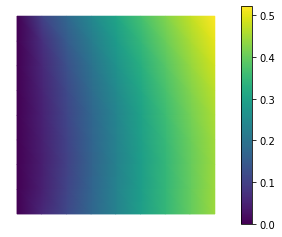

In [220]:
import numpy as np

basis0 = basis.with_element(fem.ElementQuad0())
rho0 = 0.5 * np.ones(basis0.nelems)

K = fem.asm(momentum_flux, basis, rho=basis0.interpolate(rho0))
B = f * fem.asm(loading, load_basis)
u = fem.solve(*fem.condense(K, B, x=u0, I=I))

from skfem.visuals.matplotlib import plot
plot(mesh, u[basis.nodal_dofs[1]], shading='gouraud', colorbar=True)

## Target function for topology optimization

In [221]:
def target_function(design):
    # Assembly
    K = fem.asm(momentum_flux, basis, rho=basis0.interpolate(design))
    B = f * fem.asm(loading, load_basis)

    # Solution
    u = fem.solve(*fem.condense(K, B, x=u0, I=I))
    
    # Evaluation of strain energy
    return 0.5 * u @ K @ u

## Optimization

     fun: 0.008091053978522108
     jac: array([-6.95218332e-04, -2.12120358e-06, -5.45814983e-04, -4.44049481e-04,
       -2.27206503e-04,  0.00000000e+00, -4.50194115e-04, -3.88784567e-04,
       -5.85967675e-04,  2.21189111e-09, -5.50500001e-04, -3.63172847e-04,
       -4.10223147e-04, -4.74342727e-04, -4.04090853e-04, -4.70747938e-04,
       -3.25364177e-04,  0.00000000e+00, -5.71786659e-04, -3.81328166e-04,
        1.62981451e-09,  0.00000000e+00, -1.26121682e-04, -4.39851196e-04,
       -5.82389184e-04,  1.86264515e-09, -4.12540627e-04, -3.71541595e-04,
       -4.03171987e-04, -2.28362740e-04, -4.58272523e-04, -4.83665150e-04,
       -6.11214666e-04,  2.56113708e-09, -5.19146095e-04, -4.19900636e-04,
       -3.85138788e-04,  0.00000000e+00, -3.54162999e-04, -3.97858093e-04,
       -5.61058987e-04,  3.37604433e-09, -4.51798667e-04, -4.27015359e-04,
       -3.71863018e-04, -4.89354599e-04, -4.80601331e-04, -7.19113857e-04,
       -4.56994982e-04, -1.72302243e-04, -4.60121199e-04, -

<AxesSubplot:>

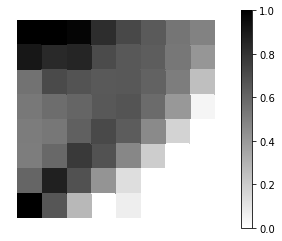

In [222]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint

# The design variables are limited to the range 0 to 1
bounds = len(rho0)*[(0.0, 1.0)]
constraints = {'type':'ineq', 'fun': lambda x : vol_constraint*len(x)-np.sum(x)}
res = minimize(target_function, rho0, constraints=constraints, bounds=bounds)
print(res)

plot(mesh, res.x, cmap=plt.cm.binary, colorbar=True)